In [7]:
import databento as db
import pandas as pd
import mplfinance as mpf
from decimal import Decimal
from dataclasses import dataclass, field
import dtale

client = db.Historical("db-VMucgt5GiD6SD9F9FVbJn83f7XT4P")
start_time = "2024-03-18T13:44:00"
end_time = "2024-03-18T13:45:00"


class Config:
    DATASET = 'GLBX.MDP3'
    UNDERLYING_DATASET = 'XNAS.ITCH'
    SYMBOLS = ['NQM4']
    UNDERLYING_SYMBOLS = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", "AVGO", "GOOGL", "COST", "GOOG", "TSLA",
    "AMD", "NFLX", "PEP", "ADBE", "LIN", "CSCO", "TMUS", "QCOM", "INTU", "INTC",
    "CMCSA", "AMAT", "TXN", "AMGN", "ISRG", "HON", "LRCX", "BKNG", "VRTX", "MU",
    "SBUX", "REGN", "ADP", "MDLZ", "ADI", "KLAC", "GILD", "PANW", "SNPS", "PDD",
    "CDNS", "ASML", "MELI", "CRWD", "CSX", "MAR", "ABNB", "PYPL", "ORLY", "CTAS",
    "PCAR", "MNST", "NXPI", "ROP", "WDAY", "LULU", "MRVL", "ADSK", "CEG", "CPRT",
    "DASH", "FTNT", "DXCM", "ROST", "MCHP", "ODFL", "FAST", "PAYX", "IDXX", "AEP",
    "CHTR", "KHC", "GEHC", "KDP", "MRNA", "CSGP", "AZN", "DDOG", "CTSH", "TTD",
    "EXC", "EA", "FANG", "VRSK", "CDW", "BKR", "CCEP", "ON", "BIIB", "TEAM",
    "ANSS", "ZS", "XEL", "GFS", "DLTR", "MDB", "TTWO", "WBD", "ILMN", "WBA", "SIRI"
    ]

    VENUE_FEES_PER_SIDE: Decimal = Decimal('0.39')
    CLEARING_FEES_PER_SIDE: Decimal = Decimal('0.05')
    FEES_PER_SIDE: Decimal = VENUE_FEES_PER_SIDE + CLEARING_FEES_PER_SIDE

@dataclass
class Trade:
    dataset: str
    underlying_dataset: str
    symbols: list
    underlying_symbols: list
    
    underlying_total_sells: int = 0
    underlying_total_buys: int = 0
    

    def run(self) -> None:
        nq_instrument_id = 13743
        
        underlying_df = client.timeseries.get_range(
            dataset=self.underlying_dataset,
            symbols=self.underlying_symbols,
            schema="tbbo",
            start=start_time,
            end=end_time,
        ).to_df()
        nq_df = client.timeseries.get_range(
            dataset=self.dataset,
            symbols=self.symbols,
            schema="tbbo",
            start=start_time,
            end=end_time,
        ).to_df()  
        nq_ohlc_df = client.timeseries.get_range(
            dataset=self.dataset,
            schema="ohlcv-1s",
            symbols=self.symbols,
            start=start_time,
            end=end_time,
        ).to_df()

        nq_df['nq_ask'] = nq_df['ask_px_00']
        nq_df['nq_bid'] = nq_df['bid_px_00']

        # Concatenate underlying_df and nq_df, then sort
        nq_and_underlying_df = pd.concat([underlying_df, nq_df]).sort_index()

        # # Forward-fill 'nq_ask' and 'nq_bid' to ensure all rows have the most recent values
        nq_and_underlying_df['nq_ask'] = nq_and_underlying_df['nq_ask'].fillna(method='ffill')
        nq_and_underlying_df['nq_bid'] = nq_and_underlying_df['nq_bid'].fillna(method='ffill')
        # return nq_and_underlying_df
        
        trades_df = pd.DataFrame(index=nq_ohlc_df.index, columns=['price', 'side', 'trade_open'])
        current_second = None
        trade_open = False
        prev_side = None
        for index, row in nq_and_underlying_df.iterrows():

            if current_second is None or current_second != index.second:

                if current_second is not None:  # Ensure this is not the first iteration
                    if self.underlying_total_sells > self.underlying_total_buys * 2:
                        if not trade_open:
                            # There is no trade open, make a trade.
                            trades_df.loc[pd.to_datetime(index).floor('S')] = {
                                'price': row['nq_bid'],
                                'side': 'S',
                                'trade_open': True
                            }
                            prev_side = 'S'
                            trade_open = True
                        elif prev_side == 'B':
                            # There is a trade open, and the previous trade was a Buy
                            trades_df.loc[pd.to_datetime(index).floor('S')] = {
                                'price': row['nq_bid'],
                                'side': 'S',
                                'trade_open': False
                            }
                            trade_open = False
                    elif self.underlying_total_buys > self.underlying_total_sells * 2:
                        if not trade_open:
                            # There is no trade open, make a trade.
                            trades_df.loc[pd.to_datetime(index).floor('S')] = {
                                'price': row['nq_ask'],
                                'side': 'B',
                                'trade_open': True
                            }
                            prev_side = 'B'
                            trade_open = True
                        elif prev_side == 'S':
                        #     # There is a trade open, and the previous trade was a Sell
                            trades_df.loc[pd.to_datetime(index).floor('S')] = {
                                'price': row['nq_ask'],
                                'side': 'B',
                                'trade_open': False
                            }
                            trade_open = False
                

                self.underlying_total_buys = 0
                self.underlying_total_sells = 0
                current_second = index.second

            if row['side'] == 'A':
                self.underlying_total_sells += 1
            elif row['side'] == 'B':
                self.underlying_total_buys += 1
                
            # trades_df.fillna(method='ffill', inplace=True)
            # Add 'prev_price' and 'prev_side' columns to trades_df
            trades_df['prev_price'] = trades_df['price'].shift(1)
            trades_df['prev_side'] = trades_df['side'].shift(1)

            # Forward fill the 'prev_price' and 'prev_side' columns
            trades_df['prev_price'] = trades_df['prev_price'].fillna(method='ffill')
            trades_df['prev_side'] = trades_df['prev_side'].fillna(method='ffill')
            
        return nq_ohlc_df, trades_df, nq_and_underlying_df

trade_instance = Trade(dataset=Config.DATASET, underlying_dataset=Config.UNDERLYING_DATASET, symbols=Config.SYMBOLS, underlying_symbols=Config.UNDERLYING_SYMBOLS)
nq_ohlc_df, trades_df, nq_and_underlying_df = trade_instance.run()
trades_df.to_csv('trades.csv', index=False) 

2024-05-08 05:46:22,613 - INFO     - Initialized Historical(gateway=https://hist.databento.com)


done


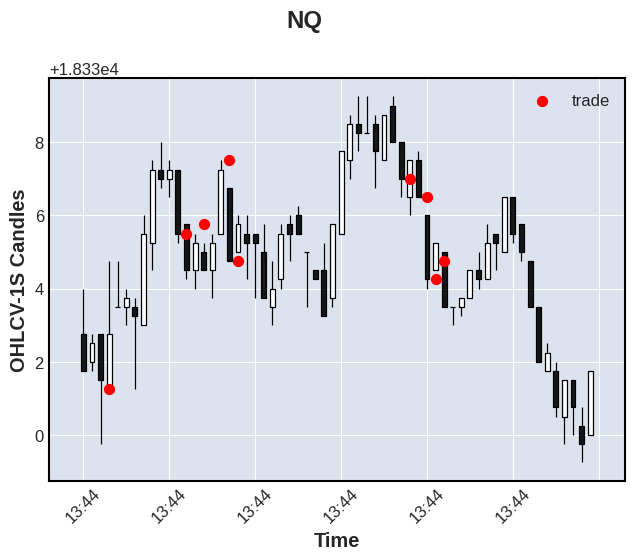

In [66]:

def chart(nq_ohlc_df: pd.DataFrame, trades_df: any) -> None:
    if trades_df.empty:
        print("No trades to plot.")
        return    
    trade_plot = mpf.make_addplot(trades_df['price'], 
                                  type='scatter', 
                                  markersize=200, 
                                  marker='.', 
                                  color='r', 
                                  label="trade")
    # trade_plot = mpf.make_addplot(trades_df['price'], 
    #                               type='scatter', 
    #                               markersize=200, 
    #                               marker='.', 
    #                               color='r', 
    #                               label="trade")
    # ap = mpf.make_addplot(trades_df['pnl'],panel=1,type='line',ylabel='Line',mav=(5,10))

    mpf.plot(
        nq_ohlc_df,
        type="candle",
        # volume=True,
        title="NQ",
        ylabel="OHLCV-1S Candles",
        ylabel_lower="Volume",
        xlabel="Time",
        addplot=trade_plot
    )


print('done')

trades_df.index = pd.to_datetime(trades_df.index).round('S')

# Call chart function
chart(nq_ohlc_df, trades_df)


In [9]:
def calculate_pnl(trades_df):
    # Initialize the 'pnl' column with NaN values
    trades_df['pnl'] = float('nan')
    last_price = None

    # Iterate through the DataFrame rows
    for index, row in trades_df.iterrows():
        if not pd.isna(row['price']) and not row['trade_open']:
            if last_price is not None:
                if row['side'] == 'S':
                    # Calculate pnl as the difference between the last price and the current price for a sell
                    pnl = last_price - row['price']
                elif row['side'] == 'B':
                    # Calculate pnl as the difference between the current price and the last price for a buy
                    pnl = row['price'] - last_price
                trades_df.at[index, 'pnl'] = pnl
            last_price = row['price']

    # Calculate the cumulative sum of pnl to get a running total
    trades_df['pnl'] = trades_df['pnl'].cumsum()

    return trades_df

# Apply the function to the trades_df DataFrame
trades_df = calculate_pnl(trades_df)

dtale.show(trades_df)